In [131]:
import numpy as np
import os
import re
import pandas as pd
from tqdm import tqdm_notebook 
from collections import defaultdict

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, r2_score, mutual_info_score
r2_scorer = make_scorer(r2_score)

from utils import shuffle
from joblib import Parallel, delayed 

import warnings
warnings.filterwarnings("ignore")

In [3]:
def similarity_metric(x1,x2, metric_type='cos'):
    '''
    correlate by neural activations
    x1: [time1,n_cells]
    x2: [time2,n_cells]
    '''
    n_cells = x1.shape[1]
    
    if metric_type == 'cos':
        norms = (np.linalg.norm(x1,axis=1)[:,None] @ np.linalg.norm(x2,axis=1)[:,None].T)
        V = (x1-x1.mean(1)[:,None])@(x2 - x2.mean(1)[:,None]).T / norms        
    return V

In [4]:
mouse = 22
track = 'Circle'

spikes_df = pd.read_csv(f"./Data_Calcium/{track}/data/CA1_{mouse}_1D_initial_data.csv", index_col=0)
spikes_events_df = pd.read_csv(f"./Data_Calcium/{track}/spikes/CA1_{mouse}_1D_initial_data_spikes.csv", index_col=0) 

print('n_steps', 'n_electrodes', spikes_df.shape)
trim=100
spikes_df = spikes_df[trim:-trim]
spikes_events_df = spikes_events_df[trim:-trim]

n_steps n_electrodes (18775, 556)


# Neural activity

In [5]:
X_neural = spikes_df.iloc[:,7:].to_numpy()
X_neural_std = StandardScaler().fit_transform(X_neural)
time = spikes_df['time_s'].values
N = len(time)
n_neurons = X_neural.shape[1]
events = spikes_events_df.values[:,1:].astype(bool)

In [ ]:
X_neural_std

# Coordinates

In [6]:
X = spikes_df["x"].to_numpy()
Y = spikes_df["y"].to_numpy()
X_green = spikes_df["x_green"].to_numpy()
Y_green = spikes_df["y_green"].to_numpy()
X_red = spikes_df["x_red"].to_numpy()
Y_red = spikes_df["y_red"].to_numpy()

coords = spikes_df[['x', 'y']].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)
phi = np.arctan2(coords_[:,0], coords_[:,1]) + np.pi

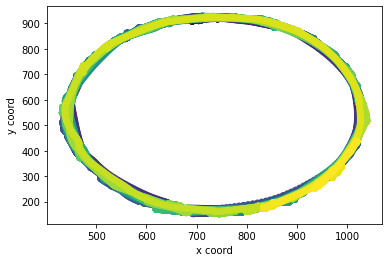

In [7]:
plt.scatter(X,Y, c=time, label='color->time')
plt.xlabel('x coord')
plt.ylabel('y coord')
# plt.legend()
plt.show()

In [8]:
# kde_phi = KernelDensity(bandwidth=0.01)
# kde_phi.fit(coords_)
# sample = kde_phi.sample(1000)
# plt.scatter(sample[:,0], sample[:,1])
# plt.scatter(coords_[:,0], coords_[:,1], alpha=0.01)

# Let's find place-neurons

In [9]:
# neurons_std = []
# active_neurons = []
# activations_threshold = 20
# for i in range(n_neurons):
#     activation_mask = events[:,i]
#     if activation_mask.sum() > activations_threshold:
#         activation_coords = coords_[activation_mask]
#         neurons_std.append(activation_coords.var(0))
#         active_neurons.append(i)
# neurons_std = np.stack(neurons_std, 0)
# active_neurons = np.array(active_neurons)

In [10]:
# plt.hist(neurons_std.flatten(), bins=50)
# plt.show()

In [11]:
# top_k = 16 # top neurons with lowest x\y std
# n_vis = 4 # visualize on n_vis \times n_vis grid
# assert top_k >= n_vis**2
# active_neurons_low_std = active_neurons[neurons_std.prod(axis=1).argsort()[:top_k]]

In [12]:
# active_neurons_boundaries = {}
# for selective_active_neuron in active_neurons_low_std:
#     mask = events[:,selective_active_neuron]
#     x_s, y_s = coords_[:,0][mask], coords_[:,1][mask]
#     active_neurons_boundaries[selective_active_neuron] = [min(x_s), min(y_s), max(x_s), max(y_s)]

In [13]:
# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(5*n_vis, 5*n_vis))
# for selective_active_neuron,ax in zip(active_neurons_low_std[:n_vis**2], axes.flatten()):
    
#     mask = events[:,selective_active_neuron]
#     times = MinMaxScaler().fit_transform(time[mask][:,None])
#     x_s, y_s = coords_[:,0][mask], coords_[:,1][mask]
#     ax.scatter(x_s, y_s, c=times)
#     ax.set_ylim(-1.1,1.1)
#     ax.set_xlim(-1.1,1.1)
#     ax.set_title(f'Neuron: {selective_active_neuron}, Total in-place actiations: {mask.sum()}')
# plt.show()

# plt.figure()
# for selective_active_neuron, boundaries in active_neurons_boundaries.items():
    
#     x_s, y_s = coords_[:,0], coords_[:,1]
#     x1, y1, x2, y2 = boundaries
#     boundaries_mask = (x_s >= x1)*(x_s <= x2)*(y_s >= y1)*(y_s <= y2)
#     plt.scatter(x_s[boundaries_mask], y_s[boundaries_mask], alpha=0.01)
#     plt.ylim(-1.1,1.1)
#     plt.xlim(-1.1,1.1)
# plt.show()

In [14]:
# trm = 2500
# for n in [376, 457, 494, 442]:
#     plt.figure()
#     plt.plot(X_neural_std[:,n][trm:])
#     plt.plot(events[:,n][trm:], color='r')    
#     plt.show()

# Evolution 

In [15]:
# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(5*n_vis, 5*n_vis))
# for selective_active_neuron, ax in zip(active_neurons_low_std[:n_vis**2], axes.flatten()):
    
#     mask = events[:,selective_active_neuron]
#     activity = X_neural_std[:,selective_active_neuron]
#     times = time[mask]
#     ax.scatter(times, phi[mask])
#     ax.set_ylim(min(phi),max(phi))
#     ax.set_title(f'Neuron: {selective_active_neuron}, Total in-place actiations: {mask.sum()}')
# plt.show()

# Check regression score on selected neurons

In [16]:
# model = MultiOutputRegressor(Lasso(alpha=1e-2))
# data_numpy_shuffled, coords_shuffled = shuffle(X_neural_std, coords_)
# cv_results_orig = cross_val_score(model, data_numpy_shuffled, coords_shuffled, cv=10, verbose=False, scoring=r2_scorer)
# print('Before selection:',cv_results_orig.mean(), cv_results_orig.std())

In [17]:
# cv_results_top_k = []
# top_k_range = np.arange(3,n_neurons,10)
# for top_k in tqdm_notebook(top_k_range):
#     active_neurons_low_std = active_neurons[neurons_std.prod(axis=1).argsort()[:top_k]]
    
#     data_numpy_shuffled, coords_shuffled = shuffle(X_neural_std[:,active_neurons_low_std], coords_)

#     cv_results = cross_val_score(model, data_numpy_shuffled, coords_shuffled, cv=10, verbose=False, scoring=r2_scorer)
#     cv_results_top_k.append(cv_results.mean())

In [18]:
# plt.plot(top_k_range, cv_results_top_k, label='Top-k selected neurons')
# plt.hlines(cv_results_orig.mean(), top_k_range.min(), top_k_range.max(), colors='r', label='all neurons')
# plt.xlabel('Top-k active neurons with lowest x-y std')
# plt.ylabel('R2 score')
# plt.legend()
# plt.show()

### - why top 9 is not enough?: probably it's not single neurons, but PCA components whict doesn's represents single cells, so it is essential to use linear combinations
### - it is inherent property of these cells - they represent the coordinate only in combination with other cells
TODO:
 - check how we obtain cells activity and spikes

# Check correlations

In [19]:
# pair_corr_results = defaultdict(list)
# def return_lag_result(neuron_pair, N=100):
#     lr = []
#     n1,n2 = neuron_pair
#     x1 = X_neural_std[:,n1]
#     x2 = X_neural_std[:,n2]
#     lag_range = np.arange(1,N)[::-1]
#     for lag in lag_range:
#         lag_result = np.corrcoef(x1[:-lag], x2[lag:])[0,1]
#         lr.append(lag_result)
#     lag_range = np.arange(N)
#     for lag in lag_range:
#         if lag == 0:
#             lag_result = np.corrcoef(x1,x2)[0,1]
#         else:
#             lag_result = np.corrcoef(x1[lag:],x2[:-lag])[0,1]
#         lr.append(lag_result)
#     return lr

In [21]:
# pair_list = list(combinations(active_neurons_low_std,2))
# lr_results = Parallel(n_jobs=-1)(delayed(return_lag_result)(neuron_pair) for neuron_pair in tqdm_notebook(pair_list))
# lr_results = dict(zip(pair_list, lr_results))

In [22]:
# max_corr = [max(v) for k,v in lr_results.items()]
# plt.hist(max_corr,10)
# plt.show()

In [23]:
# lr_results_max = {}
# for k,v in lr_results.items():
#     if max(v) > 0.3:
#         lr_results_max[k] = v

In [24]:
# for k,v in lr_results_max.items():
#     plt.figure()
#     plt.plot(v)
#     plt.title(f'Neuron pair: {k}')
#     plt.xlabel('')
#     plt.show()

# Estimate high self-correlation window

# Correlation

In [25]:
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances

def kth_diag_indices(rows, cols, k):
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [26]:
C_all_time = pairwise_distances(coords_)
C_all_time = 1 - MinMaxScaler().fit_transform(C_all_time)

In [27]:
# check auto-correlation

In [96]:
V_all_time = similarity_metric(X_neural_std, X_neural_std)
# null diagonal indexes 
rows, cols = np.diag_indices_from(V_all_time)
diagonal_dt = 200
for k in np.arange(-diagonal_dt,diagonal_dt + 1):
    ind = kth_diag_indices(rows, cols, k)
    V_all_time[ind] = 0

In [97]:
V_all_time_bin = V_all_time.copy()
threshold = 0.4
V_all_time_bin[V_all_time_bin > threshold] = 1
V_all_time_bin[V_all_time_bin <= threshold] = 0

In [98]:
print('Correlation mass preserved for BIN:', (V_all_time_bin*C_all_time).sum()/ (V_all_time_bin).sum())

Correlation mass preserved for BIN: 0.9222373799131197


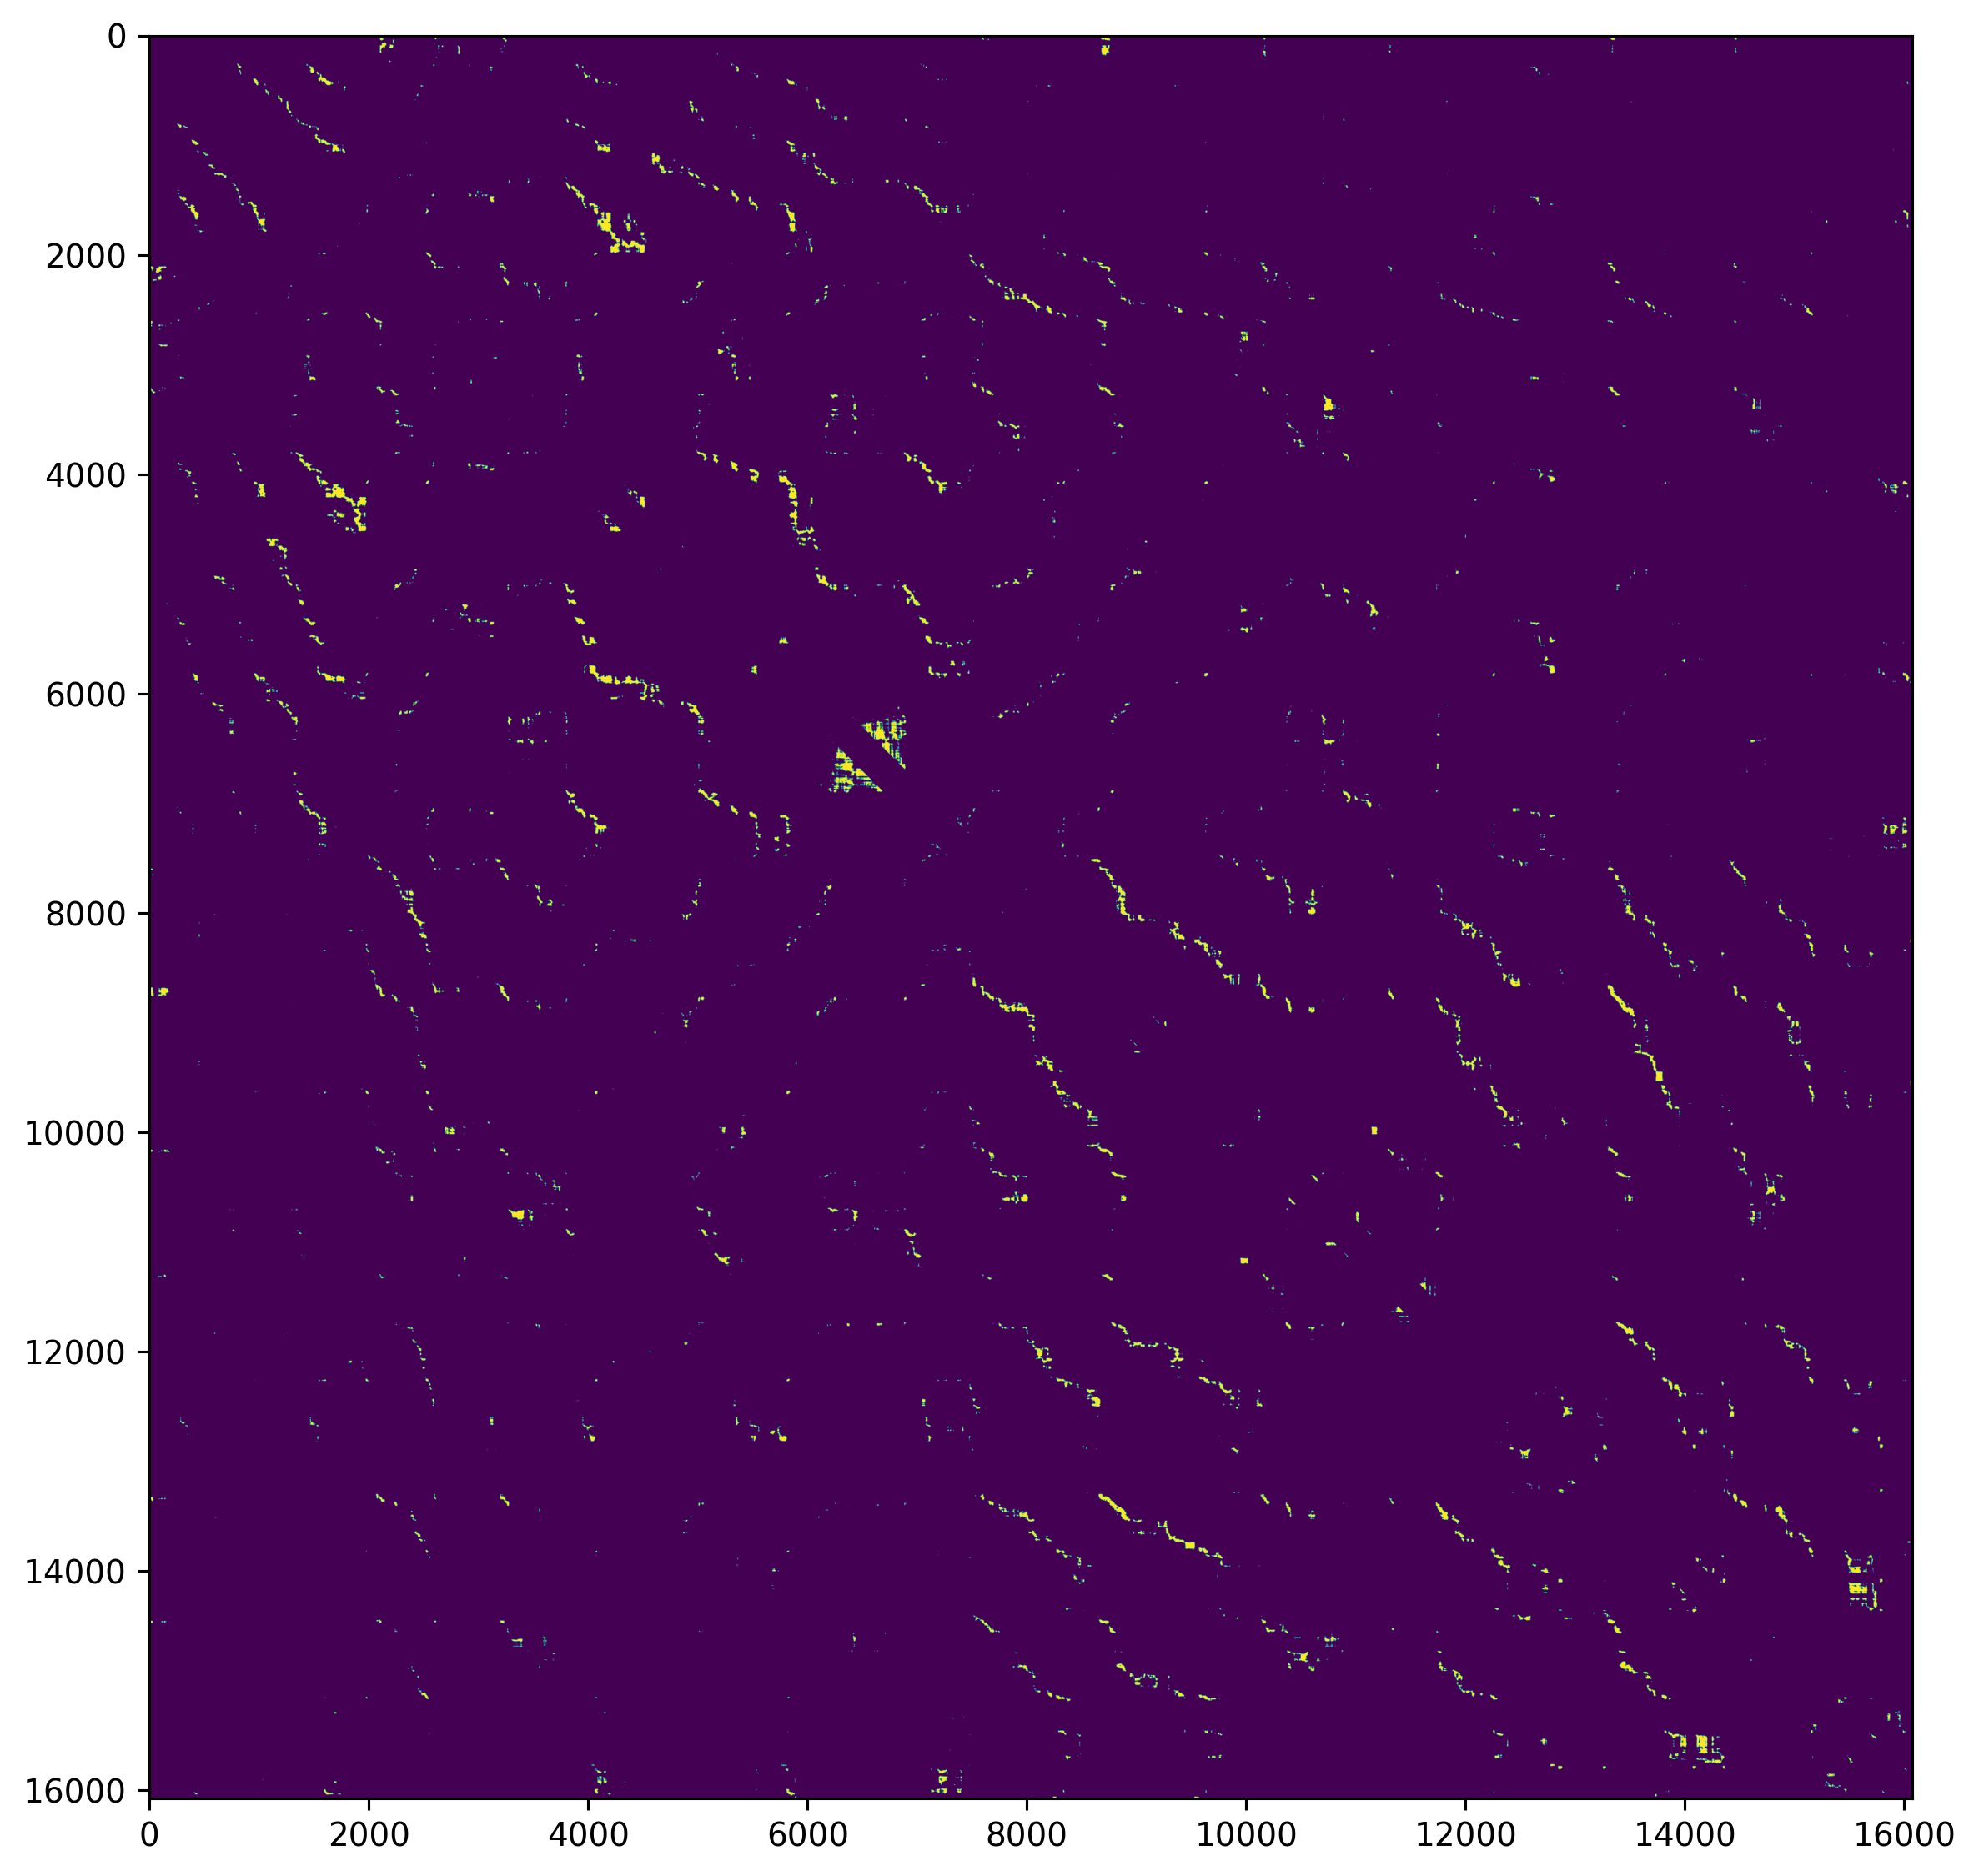

In [99]:
plt.figure(figsize=(10,10), dpi=280)
plt.imshow(V_all_time_bin[2500:, 2500:])
plt.show()

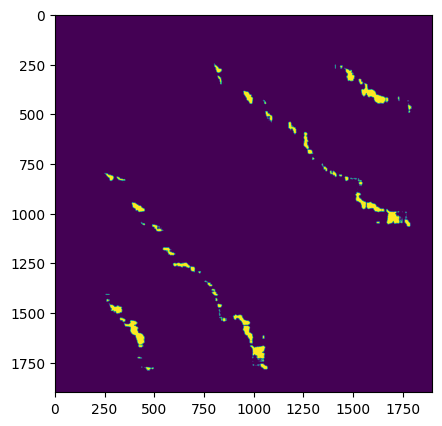

In [106]:
plt.figure(figsize=(5,5), dpi=100)
selection_start = 2500
selection_stop = 4400
V_all_time_selected = V_all_time_bin[selection_start:selection_stop, selection_start:selection_stop] # (V_all_time_bin * C_all_time*0.3)
plt.imshow(V_all_time_selected)
plt.show()

# Select correlated patterns

In [140]:
n_selected = V_all_time_selected.shape[0]
correlated_pairs_indexes = np.stack(np.meshgrid(np.arange(selection_start, selection_stop),
                                                np.arange(selection_start, selection_stop)), -1)[V_all_time_selected.astype(bool)]

In [178]:
dbscan = DBSCAN(eps=30.)
y = dbscan.fit_predict(correlated_pairs_indexes)
not_noise_mask = y!=-1

In [181]:
print('Clusters found', len(np.unique(y[not_noise_mask])))
print('Non-Noise ratio', sum(not_noise_mask)/len(not_noise_mask))

Clusters found 22
Non-Noise ratio 1.0


In [183]:
y_non_noise= y[not_noise_mask]
correlated_pairs_indexes_non_noise = correlated_pairs_indexes[not_noise_mask]

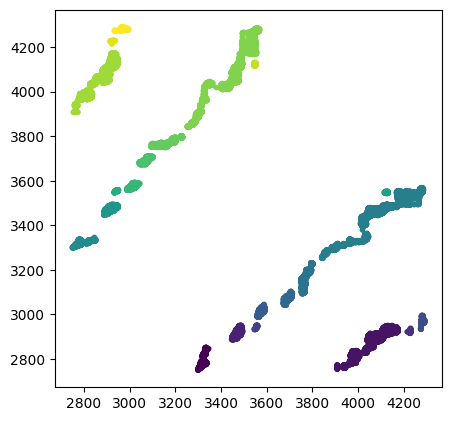

In [186]:
plt.figure(figsize=(5,5), dpi=100)
plt.scatter(correlated_pairs_indexes_non_noise[:,0], correlated_pairs_indexes_non_noise[:,1], c=y_non_noise, marker='.')
plt.show()

In [187]:
patterns_pairs = {}
for cluster_number in np.unique(y_non_noise):
    mask = y_non_noise==cluster_number
    pattern_pair_indexes = correlated_pairs_indexes[mask]
    patterns_pairs[cluster_number] = pattern_pair_indexes

In [205]:
patterns_all = []
for pattern_pair_number in patterns_pairs.keys():
#     pattern_pair_number = 0
    ind1 = np.unique(patterns_pairs[pattern_pair_number][:,0])
    ind2 = np.unique(patterns_pairs[pattern_pair_number][:,1])

    pattern1 = X_neural_std[ind1]
    pattern2 = X_neural_std[ind2]

    patterns_all.append(pattern1)
    patterns_all.append(pattern2)



In [209]:
len(patterns_all)

44

patters have high length variance

# Analyze rears

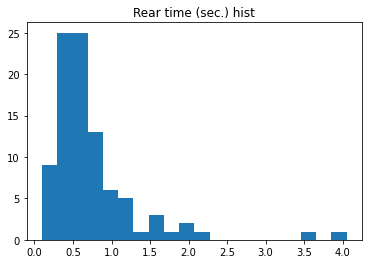

In [143]:
rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values

rear_iterval_lengths = []
rear_intervals = []
rear_intervals_indexes = []

i = 0
while i < len(rears_indicators):
    l = 0
    while rears_indicators[i] != 0.:
        l += 1
        i += 1
    if l > 0:
        rear_iterval_lengths.append(l/20.)
        rear_intervals.append([rear_times[i-l-1], rear_times[i-1]])
        rear_intervals_indexes.append([i-l-1, i-1])
        assert np.isclose(rear_iterval_lengths[-1], abs(rear_intervals[-1][0] - rear_intervals[-1][1]))
    i += 1
    
rear_intervals = np.array(rear_intervals)
rear_iterval_lengths = np.array(rear_iterval_lengths)

plt.hist(rear_iterval_lengths, bins=20)
plt.title('Rear time (sec.) hist')
plt.show()

## Rears: where

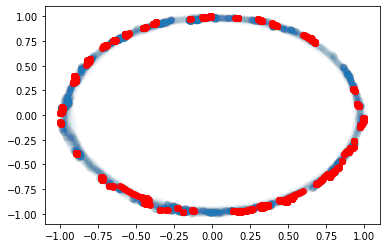

In [63]:
plt.scatter(coords_[:,0], coords_[:,1], alpha=0.01)
rears_activities = []
for interval in rear_intervals:
    t1,t2 = interval
    interval_mask = (time >= t1)*(time <= t2)
    rears_activities.append(X_neural_std[interval_mask])
    plt.scatter(coords_[:,0][interval_mask], coords_[:,1][interval_mask], color='r', alpha=0.9)

In [86]:
longest_rears_ind = np.argsort(rear_iterval_lengths)[-20:]
rear_iterval_lengths[longest_rears_ind]

array([0.9 , 0.95, 1.  , 1.05, 1.05, 1.1 , 1.1 , 1.1 , 1.15, 1.15, 1.45,
       1.5 , 1.55, 1.65, 1.8 , 2.05, 2.05, 2.15, 3.6 , 4.05])

In [110]:
splits

array([    0,  6224, 12449, 18674])

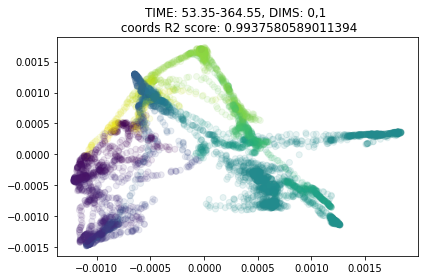

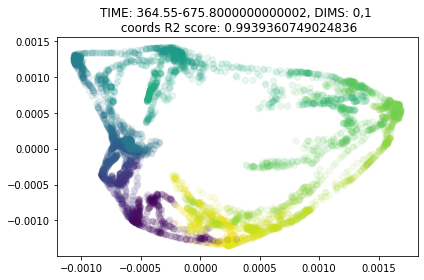

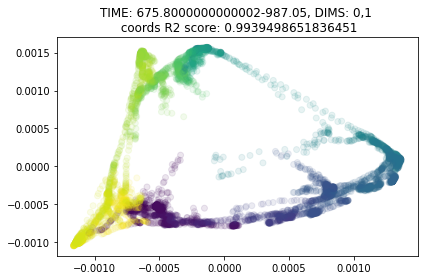

In [159]:
splits = np.linspace(0,N-1, 4).astype(int)
n_components = 10
n_vis = 3
for i in range(len(splits)-1):
    
    s1,s2 = splits[i], splits[i+1]
    t1,t2 = time[s1], time[s2]
    
    lem = SpectralEmbedding(n_components=n_components, n_neighbors=250, random_state=42)
    lem_emb = lem.fit_transform(X_neural_std[s1:s2])

    model = MultiOutputRegressor(Ridge())
    data_numpy_shuffled, coords_shuffled = shuffle(X_neural_std[s1:s2], coords_[s1:s2])
    r2 = cross_val_score(model, data_numpy_shuffled, coords_shuffled, cv=5, verbose=False, scoring=r2_scorer).mean()

#     dims_combinations = list(combinations(np.arange(n_components), 2))
#     np.random.shuffle(dims_combinations)
#     fig, axes = plt.subplots(ncols=n_vis, nrows=1, figsize=(n_vis*5,5))
    d1,d2 = 0,1
    plt.scatter(lem_emb[:,d1], lem_emb[:,d2], alpha=0.1, c=phi[s1:s2])
    plt.title(f'TIME: {t1}-{t2}, DIMS: {d1},{d2} \n coords R2 score: {r2}')
    plt.tight_layout()
    plt.show()